# SNAP - NEXUSFORGE - Utilizing data

So far, we have covered all the basic necessities for acquiring data from Nexus. This notebook will show the further capabilities of the entities.

### Setup

The token can be found in the upper right corner on https://bbp.epfl.ch/nexus/web/ and pasted here

In [1]:
import getpass
from pathlib import Path
from bluepysnap.nexus import NexusHelper

BUCKET = "public/hippocampus-hub"
TOKEN = getpass.getpass()
nexus = NexusHelper(BUCKET, TOKEN)

 ·······································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································································

### Utilizing data contained in an entity

Let's first get an entity and some of the available data:

In [2]:
entity = nexus.get_entity_by_id('https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/836087b2-4094-44ab-8874-53527a2c1fc4')
columns_to_show = {'type, name,'}

print(f"""
type          {', '.join(entity.type)}
name:         {entity.name}
species:      {entity.subject.species.label}
brain region: {entity.brainLocation.brainRegion.label}
url:          {entity.url}
nexus id:     {entity.id}
nexus link:   {entity.self}
"""
)


type          ReconstructedCell, Dataset, Entity, NeuronMorphology
name:         050921AM2
species:      Rattus norvegicus
brain region: CA1_SP
url:          https://doi.org/10.1371/journal.pcbi.1006423
nexus id:     https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/836087b2-4094-44ab-8874-53527a2c1fc4
nexus link:   https://bbp.epfl.ch/nexus/v1/resources/public/hippocampus-hub/datashapes:neuronmorphology/neuronmorphologies%2F836087b2-4094-44ab-8874-53527a2c1fc4



So, we are dealing with a `ReconstructedCell`/`NeuronMorphology` here. If we want to use this neuron, we would need the actual neuron file and then open that in some other program.

#### Downloading entities

Some entities contain downloadable data, some don't.
The downloadable data is located under `distribution` in the Nexus resource.
For example, let's see the data of items contained in `entity.distribution`:

In [3]:
for ind, item in enumerate(entity.distribution):
    print(
f"""
Item #{ind+1}
--------
type:     {item.type}
name:     {item.name}
URL:      {item.contentUrl}
location: {item.atLocation.location}
""")


Item #1
--------
type:     DataDownload
name:     050921AM2.asc
URL:      https://bbp.epfl.ch/nexus/v1/files/public/hippocampus-hub/19ed4657-7808-4a8d-8233-c1c6a7407b29
location: file:///gpfs/bbp.cscs.ch/data/project/proj126/nexus/5b5f8c5d-fe4b-463b-8c38-cb8e78a9ddcd/b/e/1/8/e/e/d/c/050921AM2.asc


Item #2
--------
type:     DataDownload
name:     050921AM2.swc
URL:      https://bbp.epfl.ch/nexus/v1/files/public/hippocampus-hub/92599b03-f564-4663-b70a-200f6581f5a0
location: file:///gpfs/bbp.cscs.ch/data/project/proj126/nexus/5b5f8c5d-fe4b-463b-8c38-cb8e78a9ddcd/7/8/b/d/3/7/3/e/050921AM2.swc



Here we can clearly see that we have two items of type `DataDownload`. Both of them contain the neuron morphology as a file: one in ASCII format, the other in SWC format. Item is downloadable only if it has an URL (`contentUrl`).

While we could technically just open the file at path shown above, we would not likely have access to it. I.e., we need to download the file. For that, `Entity` contains a `download` function.

##### __Entity.download__
`Entity.download` takes two (optional) keyword arguments: 
* `items`: List or a single item to download (i.e., one from `distribution`). By default, SNAP downloads all the items.
* `path`: Path where to save the downloaded files. By default, data is saved in directory `./.downloaded_content`

Let's try this with the SWC formatted file (`entity.distribution[1]`) and path `neurons`:

In [4]:
entity.download(items=entity.distribution[1], path='neurons')
path = 'neurons'
print(f"Contents of ./{path}:")
print('\n'.join(map(str, Path(path).iterdir())))

Contents of ./neurons:
neurons/050921AM2.swc


As we can see, we managed to download the file. Theoretically, we could now open this up in a another program like `NeuroM` by doing
```python
import neurom
morphology = neurom.io.utils.load_morphology('neurons/050921AM2.swc')
```
but there is an easier way to do all of what we just did.

#### Instantiating entities

`Entity` contains a property `instance` that downloads (if needed) and opens a nexus resource in another application all in one go.

##### __NeuronMorphology__

Let's try to instantiate the `NeuronMorphology` entity that we have:

In [5]:
morphology = entity.instance

We can now use the `morphology` as we normally would in NeuroM. For example, let's plot the morphology and the dendogram:

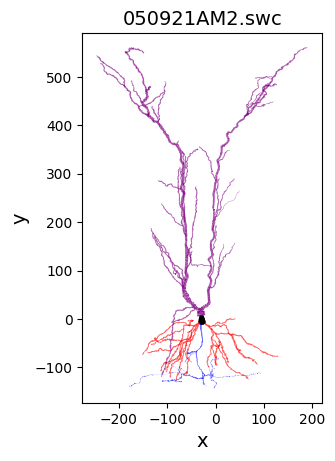

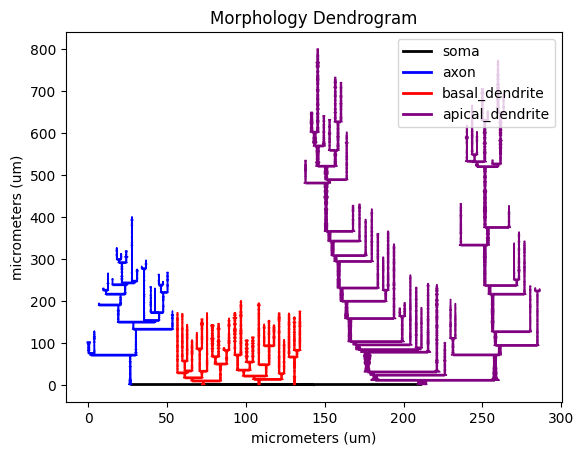

In [6]:
import neurom.view
neurom.view.matplotlib_impl.plot_morph(morphology)
_, axis = neurom.view.matplotlib_utils.get_figure()
neurom.view.matplotlib_impl.plot_dendrogram(morphology, axis)

What happened here, is that `Entity.instance` downloaded one of the available items to the default directory and opened it with NeuroM.
Let's see the contents of the default directory:

In [7]:
path = '.downloaded_content'
print(f"Contents of ./{path}:")
print('\n'.join(map(str, Path(path).iterdir())))

Contents of ./.downloaded_content:
.downloaded_content/050921AM2.swc


##### __MorphologyRelease__

For this case, we need to change a project, so let's create a new instance of `NexusHelper` and then both get and instantiate the `MorphologyRelease`:

In [8]:
BUCKET = "nse/test"
nexus = NexusHelper(BUCKET, TOKEN)

morphology_release_id = 'https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/O1-20190624-syn_morph_release'
morphology_release_entity = nexus.get_entity_by_id(morphology_release_id)
morphology_release = morphology_release_entity.instance

In this case, the data exists on GPFS and there is no need to download anything during the instantiation:

In [9]:
path = '.downloaded_content'
print(f"Contents of ./{path}:")
print('\n'.join(map(str, Path(path).iterdir())))

Contents of ./.downloaded_content:
.downloaded_content/050921AM2.swc


To actually use the morphologies in the release, we need to convert it to a dataframe and wrap the items as entities:

In [10]:
from bluepysnap.nexus.tools import wrap_morphology_dataframe_as_entities

morphology_dataframe = morphology_release.df.iloc[:10]  # Using only first ten for demoing purposes
morphologies = wrap_morphology_dataframe_as_entities(morphology_dataframe, nexus)

We can now instantiate and use the morphologies:

In [11]:
morphologies[0].instance.soma

##### __DetailedCircuit / Circuit__

In case of a `SONATA` formatted circuit, instantiating a circuit is as simple as:

In [12]:
circuit_id = "https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/20191025"
circuit_entity = nexus.get_entity_by_id(circuit_id)
circuit = circuit_entity.instance
print(circuit)

Now that we have a snap `Circuit` object, let's demonstrate it by plotting the neurons in it:

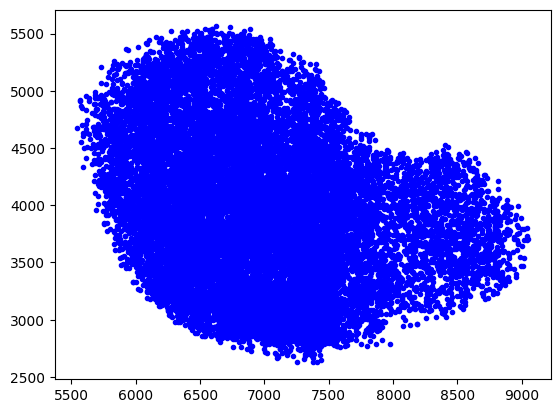

In [13]:
from bluepysnap.bbp import Cell
from matplotlib import pyplot as plt

ids = range(0, circuit.nodes.size, 100)  # take only 1% (every 100th) of all the nodes
cells = circuit.nodes.get(ids, properties=[Cell.X, Cell.Y])
plt.plot(cells[Cell.X], cells[Cell.Y], ".b");

We may also open the circuit in `bluepy`.
Since SNAP is the default opener, we need to `reopen` the entity with `bluepy`:

In [14]:
circuit_entity_bluepy = nexus.reopen(circuit_entity, tool='bluepy')  # This, of course, requires that 'bluepy' is installed
circuit_bluepy = circuit_entity_bluepy.instance
print(circuit_bluepy)

Invalid absolute path: /gpfs/bbp.cscs.ch/project/proj82/circuits/Thalamus/20191025/proj_MedialLemniscus
Invalid absolute path: /gpfs/bbp.cscs.ch/project/proj82/circuits/Thalamus/20191025/proj_CorticoThalamic


If we know from the get-go, that we want to use some other tool than the default one, we can add it as a keyword argument when we fetch the circuit:
```python
circuit_entity = nexus.get_entity_by_id(circuit_id, tool='bluepy')
```
This functionality is also supported by `NexusHelper.get_entities` and `NexusHelper.get_entities_by_query`.

Anyway, now that we have a bluepy `Circuit`, let's try to plot the same neourons as with snap:

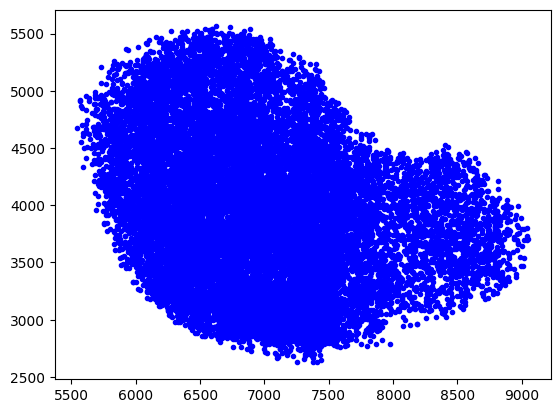

In [15]:
ids = circuit_bluepy.cells.ids()[::100]
cells = circuit_bluepy.cells.get(ids, properties=[Cell.X, Cell.Y])
plt.plot(cells[Cell.X], cells[Cell.Y], ".b");

##### __Simulation__

Instantiating simulation is no different than instantiating a circuit. Let's fetch and instantiate one with `bluepy`:

In [16]:
simulation_id = 'https://bbp.epfl.ch/nexus/v1/resources/nse/test/_/SimulationNexusTask_entity_managemen__gpfs_bbp_cscs_c__03c48af236'
simulation_entity = nexus.get_entity_by_id(simulation_id, tool='bluepy')
simulation = simulation_entity.instance
print(simulation)

We can now use the simulation. Let's do a `spikeraster_and_psth` plot for demonstrating purposes:

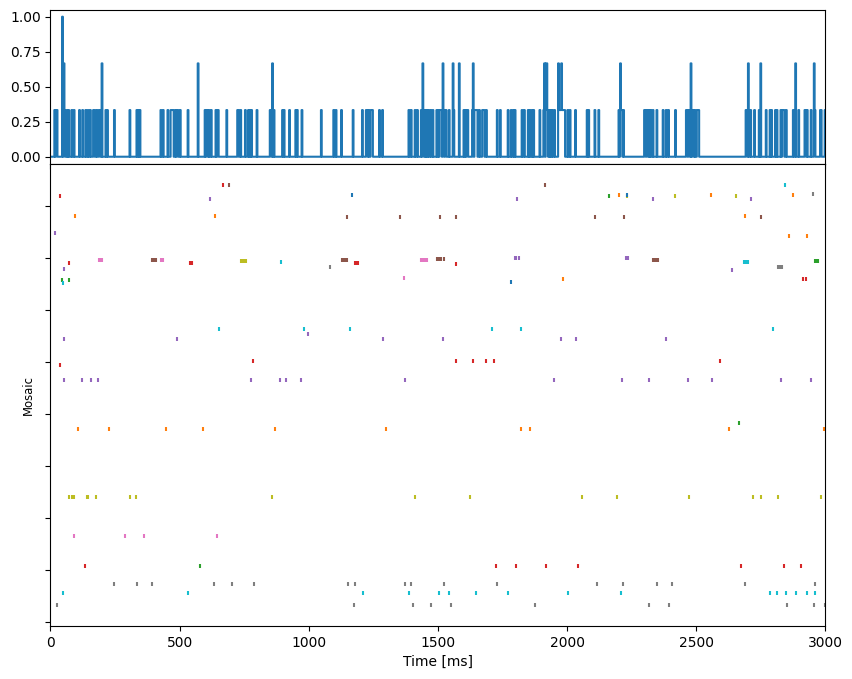

In [17]:
import numpy as np
np.random.seed(42)  # Simulation does sampling, this is just to keep the plot constant

simulation.plot.spikeraster_and_psth('soma', ['Mosaic']);

We can also open the simulation with `bglibpy`, for this, we need `Neurodamus`:

In [18]:
import os

# These need to be set for Neurodamus
os.environ["HOC_LIBRARY_PATH"] = os.environ.get(
    "HOC_LIBRARY_PATH",
    "/gpfs/bbp.cscs.ch/project/proj30/home/jupyter/NSETM-1298-entities/sources/neurodamus-core/hoc")
os.environ["BGLIBPY_MOD_LIBRARY_PATH"] = os.environ.get(
    "BGLIBPY_MOD_LIBRARY_PATH",
    "/gpfs/bbp.cscs.ch/project/proj30/home/jupyter/NSETM-1298-entities/sources/x86_64/.libs/libnrnmech.so")

simulation_bglibpy = nexus.reopen(simulation_entity, tool='bglibpy').instance
print(simulation_bglibpy)

Let's run a simulation and plot the results:

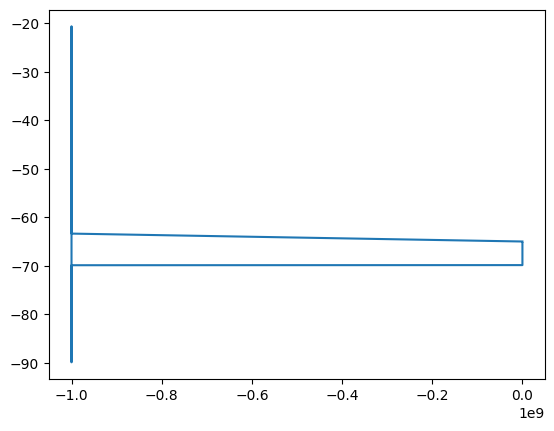

In [19]:
gid = 1
simulation_bglibpy.instantiate_gids([gid])
cell = simulation_bglibpy.cells[gid]
simulation_bglibpy.run(t_stop=1000)

import pylab
pylab.plot(cell.get_time(), cell.get_soma_voltage())
pylab.show()

### Tool management

Above we showed how we may instantiate certain types of entities using different tools.
All the previously used tools are hard-coded in the `NexusHelper` but how do we know which tools are available?

#### Available Tools

Entities are instantiated in a `Factory` class that also manages the tools. 
To print a listing of data types for which tools are available, we can do:

In [20]:
registered_types = sorted(nexus.factory.get_registered_types())
print("\n".join(registered_types))

AtlasRelease
BrainAtlasRelease
DetailedCircuit
EModelConfiguration
MorphologyRelease
NeuronMorphology
ReconstructedCell
ReconstructedPatchedCell
ReconstructedWholeBrainCell
Simulation


So to see what tools are available, for example, 'Simulation's, all we need to do is:

In [21]:
nexus.factory.get_available_tools('Simulation')

['snap', 'bluepy', 'bglibpy']

The first item in the list is always the __default__ tool. The full listing of hard-coded types and tools is: 

In [22]:
print("\n".join(f"{type_:30}: {nexus.factory.get_available_tools(type_)}" for type_ in registered_types))

AtlasRelease                  : ['voxcell']
BrainAtlasRelease             : ['voxcell']
DetailedCircuit               : ['snap', 'bluepy']
EModelConfiguration           : ['custom-wrapper']
MorphologyRelease             : ['morph-tool']
NeuronMorphology              : ['neurom']
ReconstructedCell             : ['neurom']
ReconstructedPatchedCell      : ['neurom']
ReconstructedWholeBrainCell   : ['neurom']
Simulation                    : ['snap', 'bluepy', 'bglibpy']


#### Adding custom tools

While the default tools are designed to cover most of the use cases, it may be that there's a need for another tool.
Fortunately, there is a way to add custom tools with `NexusHelper.factory.register`.

`register` expects three arguments:
* `resource_types`: list (or a single item) of nexus types that can be opened with the tool (e.g., `"Simulation"`)
* `tool`: name for the tool (e.g., `"bglibpy"`)
* `func`: callable function that will take the entity as an argument and returns the instance of the desired tool

For an example, let's create a tool named `test-tool` to open `DetailedCircuit` as an instance of `DummyCircuit` class:

In [23]:
tool_name = 'test-tool'
tool_type = 'DetailedCircuit'
def tool_function(entity):
    class DummyCircuit:
        
        def __init__(self, entity):
            self._entity = entity
        
        def print_info(self):
            separator = 80 * "-"
            print("Circuit:")
            print(separator)
            print(f"name: {self._entity.name}")
            print(f"description: {self._entity.description}")
            print(f"type: {self._entity.circuitType}")
            print(f"region: {self._entity.brainLocation.brainRegion.label}")
            print(separator)
    
    return DummyCircuit(entity)


nexus.factory.register(tool_type, tool_name, tool_function)
print(nexus.factory.get_available_tools(tool_type))

['snap', 'bluepy', 'test-tool']


As we can see, we successfully registered `test-tool` to the factory.
Now, let's try to instantiate the `DummyCircuit` with the tool:

In [24]:
dummy_circuit_entity = nexus.reopen(circuit_entity, tool=tool_name)
dummy_circuit = dummy_circuit_entity.instance
print(dummy_circuit)

<__main__.tool_function.<locals>.DummyCircuit object at 0x2aab5c7e9a00>


So far, so good, let's try if we can actually use the instance:

In [25]:
dummy_circuit.print_info()

Circuit:
--------------------------------------------------------------------------------
name: Whole Thalamus 2019.v1
description: First version of whole Thalamus model
type: Atlas-based circuit
region: Thalamus
--------------------------------------------------------------------------------


Perfect! Now that we have the tool registered, we can use it in the searches/queries.
Let's try to print the information of all the circuits we'll find:

In [26]:
circuit_entities = nexus.get_entities('DetailedCircuit', tool='test-tool')
for entity in circuit_entities:
    entity.instance.print_info()
    print() # to print an empty line between entries

Circuit:
--------------------------------------------------------------------------------
name: Thalamus microcircuit v1
description: Thalamus microcircuit v1, 2018 release
type: Microcircuit with O0 geometry
region: Thalamus
--------------------------------------------------------------------------------

Circuit:
--------------------------------------------------------------------------------
name: Thalamus microcircuit v2
description: Microcircuit v2 base
type: Microcircuit with O1 geometry
region: Thalamus
--------------------------------------------------------------------------------

Circuit:
--------------------------------------------------------------------------------
name: Thalamus microcircuit v3
description: Microcircuit with new TC-Rt and Rt-Rt syn physiology
type: Microcircuit with O1 geometry
region: Thalamus
--------------------------------------------------------------------------------

Circuit:
-----------------------------------------------------------------------

Obviously this was just a simple example. In real life use cases, the function could be something like:
```python
def open_entity_with_some_tool(entity):
    from pathlib import Path
    from somelib import SomeClass
    
    if hasattr(entity, "path_to_file"):
        file_path = entity.path_to_file
    else:
        download_path = Path('some_files')
        entity.download(items=entity.distribution[0], path=download_path)    
        file_name = entity.distribution[0].name
        file_path = download_path / file_name
    
    return SomeClass(entity.name, entity.url, file_path)
```